# Funções

In [7]:
#========================================================================================================================#
#                                   Função que plota o Mapa de Precipitação
#========================================================================================================================#
def plota_cappi_rain_PNG(cappi, ano, mes, dia, hora, min, lon_radar, lat_radar, altitude, path_output):

    """
    Retorna o mapa de precipitação em formato PNG

    Parâmetros de entrada:
                          cappi (array): grid das variáveis incluindo a precipitação
                          ano (object): ano da imagem do radar
                          mes (object): mês da imagem do radar
                          dia (object): dia da imagem do radar
                          hor (object): hora da imagem do radar
                          min (object): minuto da imagem do radar
                          lon_radar (float): longitude do radar
                          lat_radar (float): latitude do radar
                          altitude (float): altitude do radar
                          path_output (object): caminho do diretório de saída

    Parâmetros de saída:
                        figura de precipitação no formato PNG
    """

    # importa bibliotecas
    import matplotlib.pyplot as plt           # Biblioteca para gerar gráficos
    import cartopy.crs as ccrs                # Biblioteca para trabalhar com projeções de mapas
    import geopy                              # Biblioteca para geocodificação
    from geopy import distance                # Função para calculo de distância
    import numpy as np                        # Biblioteca para trabalhar com matrizes

    # define o tamanho da figura
    fig = plt.figure(figsize=(10, 7))

    # define os eixos e projeção da figura
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    # monta um objeto "display" do Py-ART
    display = pyart.graph.GridMapDisplay(cappi)

    # corrige o nível do cappi levando em conta a altitude do radar
    # para mostrar corretamente no título da figura
    display.grid.z['data'] = display.grid.z['data'] + altitude

    # plota o cappi: nivel 0 = 3000 metros
    display.plot_grid("rain_rate",
                      level=0,
                      vmin=0.1,
                      vmax=100,
                      cmap='pyart_LangRainbow12',
                      ax=ax,
                      colorbar_label='Precipitação (mm/h)',
                      mask_outside=True)

    # nomes dos eixos de longitude e latitude
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # plota os aneis de distância do radar
    aneis = [100, 250]
    origin = geopy.Point(lat_radar, lon_radar)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color='gray', label= dis)

    # recorta figura
    plt.tight_layout()

    # salva figura
    plt.savefig(f'{path_output}.png', dpi=300)

#========================================================================================================================#
#                                   Função que plota arquivo TIFF
#========================================================================================================================#
def plota_cappi_rain_TIFF(filename):

    """
    Retorna o mapa de precipitação em fomrato TIFF

    Parâmetros de entrada:
                          filename (str): nome do arquivo TIF
                          
    Parâmetros de saída:
                        figura de precipitação no formato TIF
    """

    # importa bibliotecas
    import rioxarray
    import matplotlib.pyplot as plt 
    
    # leitura do dado
    tif = rioxarray.open_rasterio(filename)

    # plota mapa
    tif.plot(vmin=0.1, vmax=100, cmap='pyart_LangRainbow12')

    # salva figura
    plt.savefig(f'{filename}.png', dpi=300)

# Processamento

.... PROECESSANDO DATA= 2022 05 03 00 13
.... PROECESSANDO DATA= 2022 05 03 00 22
CPU times: total: 2min 21s
Wall time: 3min 7s


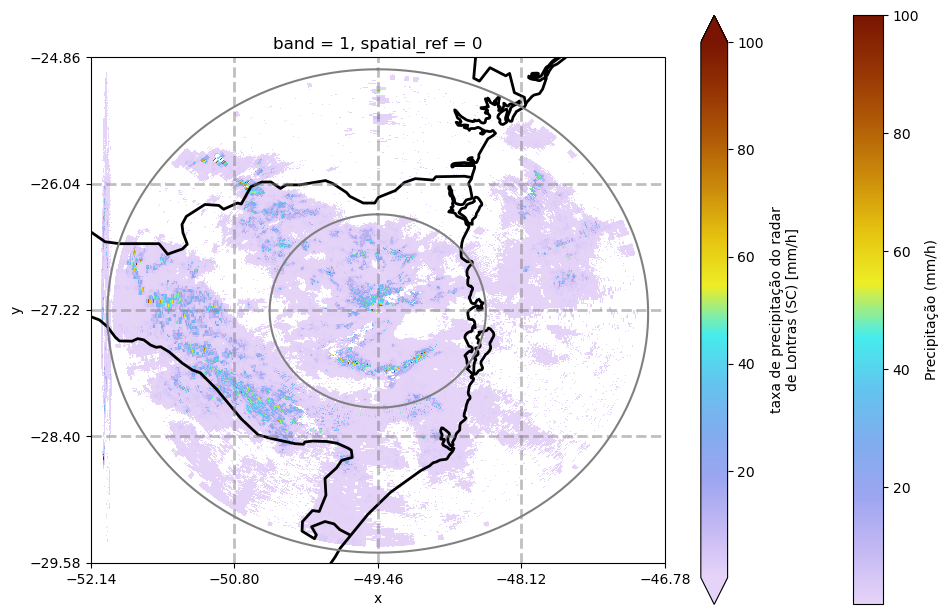

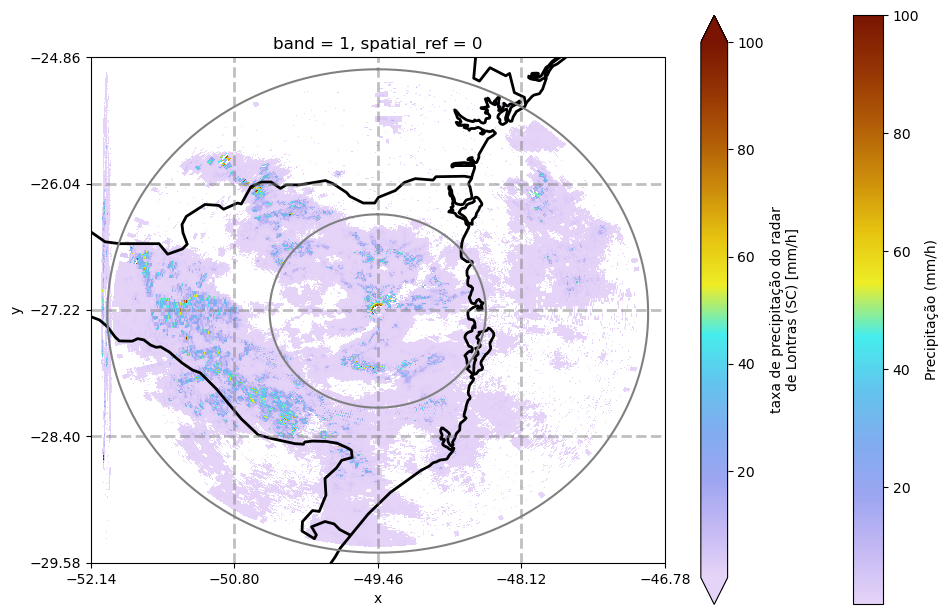

In [8]:
%%time
#========================================================================================================================#
#                                             IMPORTA BIBLIOTECAS
#========================================================================================================================#
import pyart
import glob
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rio
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#========================================================================================================================#
#                                             DATA DE PROCESSAMENTO
#========================================================================================================================#
ano, mes, dia  = '2022', '05', '03'

#========================================================================================================================#
#                                             CAMINHO DOS DIRETÓRIOS
#========================================================================================================================#
dir_input = f'input/{ano}-{mes}-{dia}'
dir_output = f'output/rain_rate/{ano}-{mes}-{dia}'

#========================================================================================================================#
#                                             IMPORTA BIBLIOTECAS
#========================================================================================================================#
# lista os arquivos do radar
files = sorted(glob.glob(f'{dir_input}/*.hdf5')) ; files=files[0:2]

# loop dos arquivos
for file in files:
    
    #-------------------------------------------------------#
    #            LEITURA DO DADO DO RADAR
    #-------------------------------------------------------#
    # leitura do arquivo
    #radar = pyart.aux_io.read_gamic(file)
    radar = pyart.aux_io.read_odim_h5(file)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]

    # extrai a data do dado do radar
    data = pyart.util.datetime_from_grid(radar)

    # extra a data da imagem
    ano = str(data.year)
    mes = str(data.month).zfill(2)
    dia = str(data.day).zfill(2)
    hor = str(data.hour).zfill(2)
    min = str(data.minute).zfill(2)
    print('.... PROECESSANDO DATA=', ano,mes,dia,hor,min)

    #-------------------------------------------------------#
    #          DEFINIÇÕES DA GRADE DO CAPPI
    #-------------------------------------------------------#
    # função que calcula a quantidade de pontos em x e y
    def compute_number_of_points(extent, resolution):
        return int((extent[1] - extent[0]) / resolution)

    # limites da grade
    z_grid_limits = (3000. - altitude, 3000. - altitude)
    y_grid_limits = (-250_000., 250_000.)
    x_grid_limits = (-250_000., 250_000.)

    # resolução da grade em metros
    grid_resolution = 1000

    # pontos em X, Y e Z
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = 1
    
    #-------------------------------------------------------#
    #            CALCULA PRECIPITAÇÃO
    #-------------------------------------------------------#
    # guarda os campos de cada variável
    refl = radar.fields['reflectivity_horizontal']['data']
    zdr = radar.fields['differential_reflectivity']['data']
    kdp = radar.fields['specific_differential_phase']['data']

    # chuva usando somente KDP
    rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)

    # Marshall Palmer para Z-R
    z = np.ma.power(10.0, refl/10) # transforma de dBZ para mm6/m3
    r_zr = (np.ma.power(z/200, 1/1.6))

    # copia o campo r_zr como matriz de saida
    rain = r_zr

    # agora verifica os limiares para uso com Z-ZDR-KDP
    idx = np.where(r_zr <= 6)
    rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))

    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))

    idx = np.where(r_zr > 50)
    rain[idx] = rkdp[idx]

    #-------------------------------------------------------#
    #         ADICIONA O CAMPO DE PRECIPITAÇÃO
    #-------------------------------------------------------#
    # insere o campo calculado no volume de dbz para poder calcular o cappi e retirar as informações que vem no cabeçalho do arquivo original.
    # maiores informações sobre a função [.add_field_like](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.core.Radar.add_field_like.html) do Py-ART.
    radar.add_field_like('reflectivity_horizontal', 'rain_rate', rain)
    radar.fields['rain_rate']['units'] = 'mm/h'
    radar.fields['rain_rate']['standard_name'] = 'Rain_Rate'
    radar.fields['rain_rate']['long_name'] = 'Rain Rate'

    #-------------------------------------------------------#
    #                  GERA CAPPI
    #-------------------------------------------------------#
    cappi = pyart.map.grid_from_radars(radar, 
                                       grid_shape = (z_grid_points,
                                                     y_grid_points,
                                                     x_grid_points),
                                       grid_limits = (z_grid_limits,     # alturas
                                                      y_grid_limits,     # latitudes
                                                      x_grid_limits),    # longitudes
                                       grid_origin = (lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam', min_radius=2000.0,
                                       weighting_function='Nearest')

    # cria a pasta de saídade com o nome da data daquela dia
    os.makedirs(f'{dir_output}', exist_ok=True)

    # nome do arquivo de saída
    path_and_fileout = f'{dir_output}/lontras_cappi_3000m_taxa_precipitacao_{ano}{mes}{dia}_{hor}{min}'
    
    # plota cappi e salva mapa no formato PNG
    plota_cappi_rain_PNG(cappi, ano, mes, dia, hor, min, lon_radar, lat_radar, altitude, path_and_fileout)
    
    #-------------------------------------------------------#
    #          SALVA ARQUIVO NO FORMATO NETCDF
    #-------------------------------------------------------#
    # Maiores informações sobre a função que transforma DATASET para TIFF
    # acessar: https://corteva.github.io/rioxarray/stable/examples/convert_to_raster.html
    
    # transforma para Xarray
    cappi_dataset = cappi.to_xarray()

    # extrai o dataste para array 
    rain_rate_values = cappi_dataset['rain_rate'][0,0,:,:].values 
    
    rain_rate_values = np.flipud(rain_rate_values) # inverte a matriz
    
    lats_values = cappi_dataset['lat'][:,0].values
    lons_values = cappi_dataset['lon'][:,0].values

    # define as variáveis
    data_vars = {'rain_rate': (('lat', 'lon'), rain_rate_values, {'units': 'mm/h', 'long_name': 'taxa de precipitação do radar de Lontras (SC)', '_FillValue': 0})}

    # define as coordenadas 
    coords = {'lat': lats_values, 'lon': lons_values}
    
    # define atributos
    texto = """CAPPI de precipitação calculado através da equação que utiliza Refletividade Horizontal (ZH), Refletividade Diferencial (ZDR) e Coeficiente de Correlação (ROHV) de Ryzhkov et al (2005): https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml. Os dados são referentes ao radar de Lontras (SC) e possuem resolução espacial horizontal de 1000 metros. """

    attrs = {'description': texto,                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    rain_rate_dataset = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

    # salva arquivo netcdf
    rain_rate_dataset.to_netcdf(f'{path_and_fileout}.nc', encoding={'rain_rate': {'zlib': True}})

    #-------------------------------------------------------#
    #         SALVA ARQUIVO NO FORMATO TIFF
    #-------------------------------------------------------#
    # dimensões
    rain_rate_tiff = rain_rate_dataset.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    rain_rate_tiff.rio.crs

    # define a projeção CRS
    rain_rate_tiff.rio.write_crs('epsg: 4326', inplace=True)

    # salva arquivo
    rain_rate_tiff.rio.to_raster(f'{path_and_fileout}.tiff',
                                 driver="GTiff",
                                 compress="LZW")

    #-------------------------------------------------------#
    #           PLOTA FIGURA EM FORMATO TIFF
    #-------------------------------------------------------#
    plota_cappi_rain_TIFF(f'{path_and_fileout}.tiff')

In [9]:
# exibindo as chaves dos campos do objeto radar
radar.fields.keys()

dict_keys(['total_power_horizontal', 'velocity_horizontal', 'velocity_vertical', 'total_power_vertical', 'reflectivity_horizontal', 'reflectivity_vertical', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'specific_differential_phase', 'rain_rate'])

In [10]:
# mostra os campos disponíveis
pd.DataFrame(cappi.fields.keys())

,0
0,velocity_horizontal
1,total_power_vertical
2,velocity_vertical
3,cross_correlation_ratio
4,specific_differential_phase
5,total_power_horizontal
6,rain_rate
7,reflectivity_horizontal
8,differential_reflectivity
9,differential_phase


In [11]:
# informações do arquivo netcdf
import xarray as xr
ds = xr.open_dataset(f'{path_and_fileout}.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 500, lon: 500)
Coordinates:
  * lat        (lat) float64 -29.45 -29.45 -29.44 ... -24.98 -24.97 -24.96
  * lon        (lon) float64 -52.04 -52.04 -52.04 ... -51.94 -51.94 -51.94
Data variables:
    rain_rate  (lat, lon) float32 ...
Attributes:
    description:     CAPPI de precipitação calculado através da equação que u...
    creation_data:  2024-07-18 17:06:01.881061
    author:         Enrique V. Mattos
    email:          enrique@unifei.edu.br

In [12]:
# acessando informações do arquivo TIFF
!rio info lontras_cappi_3000m_taxa_precipitacao_20220503_0013.tiff

{"blockysize": 4, "bounds": [-52.042728044663335, -24.955654259334523, -51.94035442040636, -29.45919934007505], "colorinterp": ["gray"], "compress": "lzw", "count": 1, "crs": "EPSG:4326", "descriptions": ["taxa de precipita\u00e7\u00e3o do radar de Lontras (SC)"], "driver": "GTiff", "dtype": "float32", "height": 500, "indexes": [1], "interleave": "band", "lnglat": [-51.99154123253484, -27.207426799704784], "mask_flags": [["nodata"]], "nodata": 0.0, "res": [0.00020474724851394678, 0.00900709016148105], "shape": [500, 500], "tiled": false, "transform": [0.00020474724851394678, 0.0, -52.042728044663335, 0.0, 0.00900709016148105, -29.45919934007505, 0.0, 0.0, 1.0], "units": [null], "width": 500}
